In [11]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\vishn\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [12]:
# load dataset
series = read_csv('RF9.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [13]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [14]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [15]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [16]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [18]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.41870725],
       [-0.46835983],
       [ 0.01211055],
       [ 0.125151  ],
       [ 0.29469347],
       [-0.99604356],
       [ 0.44878447],
       [ 0.08376761],
       [ 0.03656359],
       [-0.12528214],
       [ 0.06226212],
       [-0.08560579],
       [ 0.17103098],
       [ 0.916046  ],
       [-0.36165047],
       [ 0.14637518],
       [ 0.24418138],
       [ 0.09679733],
       [ 0.17009176],
       [ 0.13970132],
       [ 0.36312634],
       [ 0.18979882],
       [ 0.05209094]], dtype=float32)

In [19]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=6026.348171, Expected=4500.000000
Month=2, Predicted=5796.445153, Expected=6880.000000
Month=3, Predicted=4361.264704, Expected=6900.000000
Month=4, Predicted=6726.297130, Expected=7000.000000
Month=5, Predicted=6691.112665, Expected=7100.000000
Month=6, Predicted=7206.404205, Expected=7110.000000
Month=7, Predicted=8116.848301, Expected=7120.000000
Month=8, Predicted=9641.537651, Expected=5470.000000
Month=9, Predicted=11823.585649, Expected=5660.000000
Month=10, Predicted=14649.325542, Expected=5780.000000
Month=11, Predicted=15498.125162, Expected=5790.000000
Month=12, Predicted=16376.587512, Expected=5475.000000


Test RMSE: 5464.605


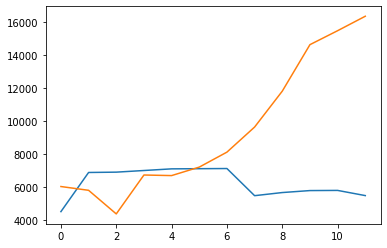

In [20]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [21]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [22]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [23]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
series = read_csv('RF9.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [24]:
# repeat experiment
repeats = 15
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

1) Test RMSE: 1529.157
2) Test RMSE: 1646.048
3) Test RMSE: 1417.315
4) Test RMSE: 1381.847
5) Test RMSE: 1396.737
6) Test RMSE: 3925.978
7) Test RMSE: 5667.783
8) Test RMSE: 4891.545
9) Test RMSE: 3209.285
10) Test RMSE: 2544.055
11) Test RMSE: 2398.798
12) Test RMSE: 2585.712
13) Test RMSE: 1175.515
14) Test RMSE: 1432.901
15) Test RMSE: 1624.393


              rmse
count    15.000000
mean   2455.138007
std    1395.176896
min    1175.514979
25%    1425.107715
50%    1646.048184
75%    2897.498832
max    5667.783471


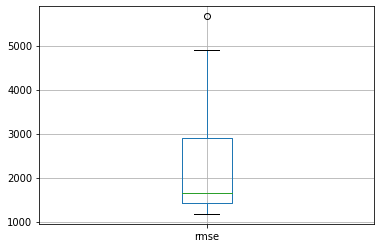

In [25]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()